# 2. 音频转音频任务(Audio-to-Audio)

- "音频转音频"任务，其输入为音频，输出为一个或多个生成的音频。典型的示例任务包括：
    - 语音增强(Speech Enhancement)：
        - 语音增强任务顾名思义，其目标是通过消除噪声来提升音频质量。现有多个开源库可用于实现此任务，例如 Speechbrain、Asteroid 和 ESPNet。我们这里主要使用Transformers框架库。
    - 语音源分离(Audio Source Separation)：
        - 音频源分离技术能够从混合音频中分离出来自不同声源的独立音轨。例如，若有一段多人同时讲话的音频文件，该技术可为每位说话人生成独立的音频文件。随后，您可运用自动语音识别系统，从各分离音轨中提取文本内容，作为系统处理的初始步骤。
        - 音频到音频技术同样适用于音频降噪：它能将人声与背景噪声分离为两条独立音轨。这项技术在处理含噪声的多人对话音频时尤为实用——既可分离出每位说话人的独立音频，又能单独提取背景噪声轨。

## 2.1. 音频转音频任务模型应用

- 带transformers中没有提供About Audio-to-Audio相关的Pipeline实现，提供的实现都是第三方的实现，比如speechbrain等，Transformers框架提供的API只有如下4个实现：
    - AudioClassificationPipeline（语音分类）
    - AutomaticSpeechRecognitionPipeline（语音识别）
    - TextToAudioPipeline（文本转语音）
    - ZeroShotAudioClassificationPipeline（零样本音频分类）

- 在阿里达摩院的ModelScope提供了很多Audio-to-Audio的模型
    - 语音降噪（语音增强）
    - 回声消除
    - 语音分离

### (1) 语音分离

- 模型我们在魔塔选择下载量最多的模型`MossFormer语音分离-单麦-8k`(iic/speech_mossformer_separation_temporal_8k),作者是**通义实验室**。
    - 下载方式：`git clone https://www.modelscope.cn/iic/speech_mossformer_separation_temporal_8k.git`
    - 模型大小大约170M。

- MossFormer语音分离-单麦-8k模型介绍：
    - 我们日常可能会遇到在嘈杂环境中进行语言交流的场景，比如在人多的餐厅里或者拥挤的人群中，同时存在着许多不同的说话人的声音，这时听者可能只对一个主说话人的声音感兴趣，其他说话人的声音形成了一种听觉干扰，幸运的是，我们人类的听觉系统具有选择性聆听的功能，可以在多个说话人的声音中选择性的聆听自己感兴趣的声音。1953年，Colin Cherry提出了著名的”鸡尾酒会”问题，即在鸡尾酒会那样的嘈杂环境中，我们似乎也能毫不费力地在其他人的说话声和环境噪声的包围中听到一个人的说话内容，也就是说人类听觉系统能轻易地将一个人的声音和另一个人的分离开来。虽然人类能轻易地分离人声，但事实证明，在这项基本任务中，构建一个能够媲美人类听觉系统的自动化系统是很有挑战性的。“语音分离”（Speech Separation）便来源于“鸡尾酒会问题”，由于麦克风采集的音频信号中除了主说话人之外，还可能包括噪声、其他人说话的声音、混响等干扰。语音分离的目标即是把目标语音从背景干扰中分离出来。其应用范围不仅包括听力假体、移动通信、鲁棒的自动语音以及说话人识别等，最近也被广泛应用在各个语音方向的机器学习场景中。
    - 根据干扰的不同，语音分离任务可以是单纯的多说话人分离，也可以包括噪声消除和解混响等附加任务。在没有噪声和混响的情况下，单纯的语音分离任务已经被研究了几十年，从最初的传统信号处理算法到最近的深度学习算法，算法的分离性能有了明显的进步。我们的研究目标是在现有深度学习算法的基础上，通过融入更先进的门控注意力机制和带记忆的深度卷积网络，从而更有效地对长语音序列进行建模和学习，大幅提升深度学习分离算法的性能。
    - MossFormer语音分离模型是基于带卷积增强联合注意力(convolution-augmented joint self-attentions）的门控单头自注意力机制的架构（gated single-head transformer architecture ）开发出来的，通过采用联合局部和全局自注意力架构，同时对局部段执行完整自注意力运算和对全局执行线性化低成本自注意力运算，有效提升当前双路径（Dual-path） Transformer 模型在远程元素交互和局部特征模式的建模能力。除了强大的远程建模能力外，我们还通过使用卷积运算来增强 MossFormer 在局部位置模式的建模能力。因此，MossFormer 的性能明显优于之前的模型，并在 WSJ0-2/3mix 和 WHAM!/WHAMR! 上取得了最先进的结果。

- 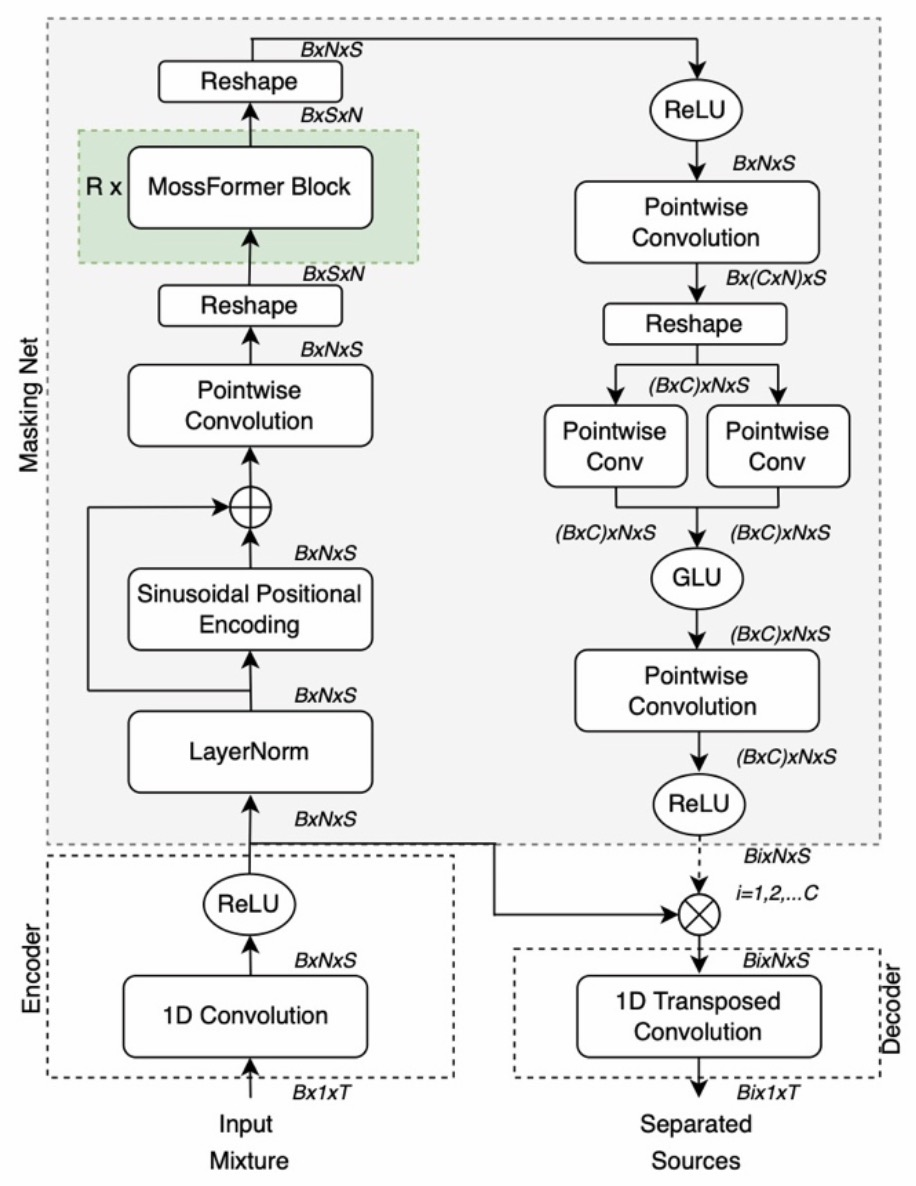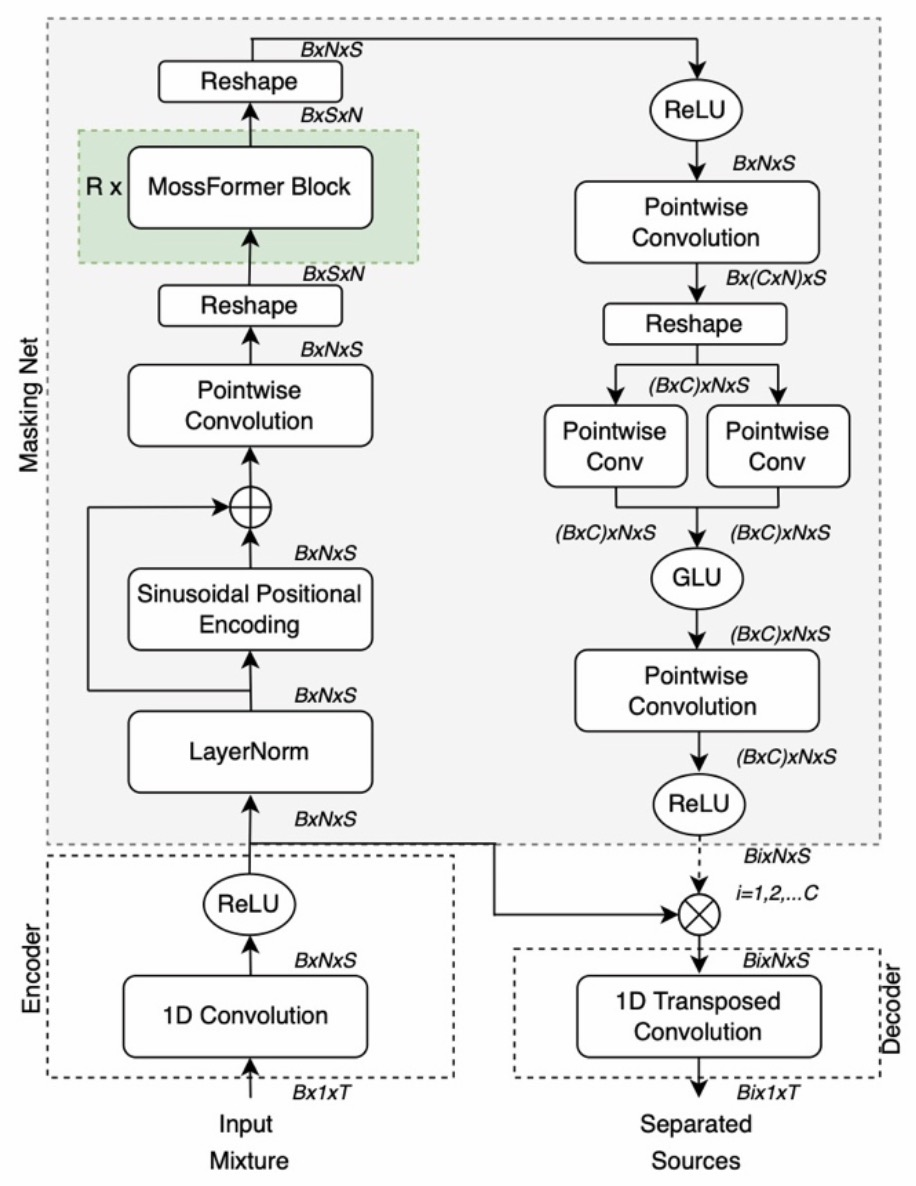

- MossFormer模型网络结构说明：
    - MossFormer模型由一个卷积编码器-解码器结构和一个掩蔽网络组成。编码器-解码器结构负责特征提取和波形重建，编码器负责特征提取，由一维 (1D) 卷积层 (Conv1D) 和整流线性单元 (ReLU) 组成，后者将编码输出限制为非负值。解码器是一维转置卷积层，它使用与编码器相同的内核大小和步幅。 掩码网络执行从编码器输出到𝐶组掩码的非线性映射，掩码网络的主组成部分是MossFormer模块，一个MossFormer 模块由四个卷积模块、缩放和偏移操作、联合局部和全局 单头自注意力（SHSA） 以及三个门控操作组成，负责进行长序列的处理。
    - 理论上，MossFormer模型框架可以支持任意多说话人和任意环境下的语音分离任务。

- 因为该模型使用的是第三方框架speechbrain，所以需要先安装该框架：
    - `pip install speechbrain`
- 同时还需要安装modelscope框架，安装指令如下：
    - `pip install modelscope`
- 其他可能需要安装的模块（这个会因个人环境不同而有差异）：
    - `pip install addict`
    - `pip install oss2`
    - `pip install sortedcontainers`
    - `pip install datasets==2.21.0`
    - `pip install pandas==2.3.3`
    - `pip install pyarrow==18.0.0`
    - `pip install rotary-embedding-torch`

- 该模型会使用第三方库SoundFile，在window中不需要安装（已经自动安装）。

- 在模型文件中还包含2个混音测试语音文件：
    - `mix_speech.wav`
    - `mix_speech1.wav`

In [5]:
import numpy
import soundfile as sf
from modelscope.pipelines import pipeline
from modelscope.utils.constant import Tasks

# input可以是url也可以是本地文件路径
input = './sounds/mix_speech1.wav'
separation = pipeline(Tasks.speech_separation, model='F:/03Models/speech_mossformer_separation_temporal_8k')
result = separation(input)
for i, signal in enumerate(result['output_pcm_list']):
    save_file = f'./sounds/output_spk{i}.wav'
    sf.write(save_file, numpy.frombuffer(signal, dtype=numpy.int16), 8000)
print("语音分离完毕！")

2026-02-05 11:49:02,170 - modelscope - INFO - loading model...
2026-02-05 11:49:02,170 - modelscope - INFO - initiate model from F:/03Models/speech_mossformer_separation_temporal_8k
2026-02-05 11:49:02,170 - modelscope - INFO - initiate model from location F:/03Models/speech_mossformer_separation_temporal_8k.
2026-02-05 11:49:02,172 - modelscope - INFO - initialize model from F:/03Models/speech_mossformer_separation_temporal_8k
2026-02-05 11:49:02,428 - modelscope - WARNING - No preprocessor field found in cfg.
2026-02-05 11:49:02,429 - modelscope - WARNING - No val key and type key found in preprocessor domain of configuration.json file.
2026-02-05 11:49:02,430 - modelscope - WARNING - Cannot find available config to build preprocessor at mode inference, current config: {'model_dir': 'F:/03Models/speech_mossformer_separation_temporal_8k'}. trying to build by task and model information.
2026-02-05 11:49:02,430 - modelscope - INFO - No preprocessor key ('speech_mossformer_separation_tem

语音分离完毕！


- 代码说明:
    - 分离完毕后，生成两个wav文件，`output_spk0.wav`与`output_spk1.wav`，语音分离效果非常好，这是两个语义混在一起的情况，实际上可以支持任意多个语音分离。
    - 在使用的多个模块，要注意版本：
        - `pip install datasets==2.21.0`
        - `pip install pandas==2.3.3`
        - `pip install pyarrow==18.0.0`
    - 其中pyarrow版本太高，可能不支持，导致运行错误。

### (2) 语音降噪

- 语音降噪应用介绍：
    - 我们日常可能会碰到一些录音质量不佳的场景。比如，想录制一段干净的语音却发现周围都很吵，录制的语音里往往混杂着噪声。当我们在噪杂的地铁或者巴士上通电话，为了让对方听清楚，不得不提高嗓门和音量。这都是因为环境噪声的影响，使我们在使用语音应用时出现障碍。这是语音通讯中一个普遍存在且又非常棘手的问题。语音质量（quality）和可懂度（intelligibility）容易受到环境噪声、拾音设备、混响及回声的干扰，使通话质量和交流效率大幅降低，如何在嘈杂的环境中保持较高的语音质量和可懂度一直以来是众多企业和学者追求的目标。
    - 语音降噪问题通过多年研发积累，已经取得一定的突破，尤其针对复杂环境中的语音降噪问题，通过融入复数域深度学习算法，在性能上获得大幅度的提升，在保障更小语音失真度的情况下，最大限度地消除背景噪声，还原目标语音的清晰度，因而语音降噪模型也通常被叫做语音增强模型。
    - 语音降噪模型的作用是从污染的语音中提取目标语音，还原目标语音质量和可懂度，同时提升语音识别的效果和性能。我们的语音降噪模型只需要输入单麦克风的录音音频，便能够输出降噪后的干净语音音频，即保持音频的格式不变，仅消除音频中的噪声和混响部分，最大限度地保留原始语音。

- FRCRN模型介绍：
    - FRCRN语音降噪模型是基于频率循环 CRN (FRCRN) 新框架开发出来的。该框架是在卷积编-解码(Convolutional Encoder-Decoder)架构的基础上，通过进一步增加循环层获得的卷积循环编-解码(Convolutional Recurrent Encoder-Decoder)新型架构，可以明显改善卷积核的视野局限性，提升降噪模型对频率维度的特征表达，尤其是在频率长距离相关性表达上获得提升，可以在消除噪声的同时，对语音进行更针对性的辨识和保护。
    - 另外，我们引入前馈序列记忆网络（Feedforward Sequential Memory Network: FSMN）来降低循环网络的复杂性，以及结合复数域网络运算，实现全复数深度网络模型算法，不仅更有效地对长序列语音进行建模，同时对语音的幅度和相位进行同时增强，相关模型在IEEE/INTERSpeech DNS Challenge上有较好的表现。本次开放的模型在参赛版本基础上做了进一步优化，使用了两个Unet级联和SE layer，可以获得更为稳定的效果。如果用户需要因果模型，也可以自行修改代码，把模型中的SElayer替换成卷积层或者加上掩蔽即可。

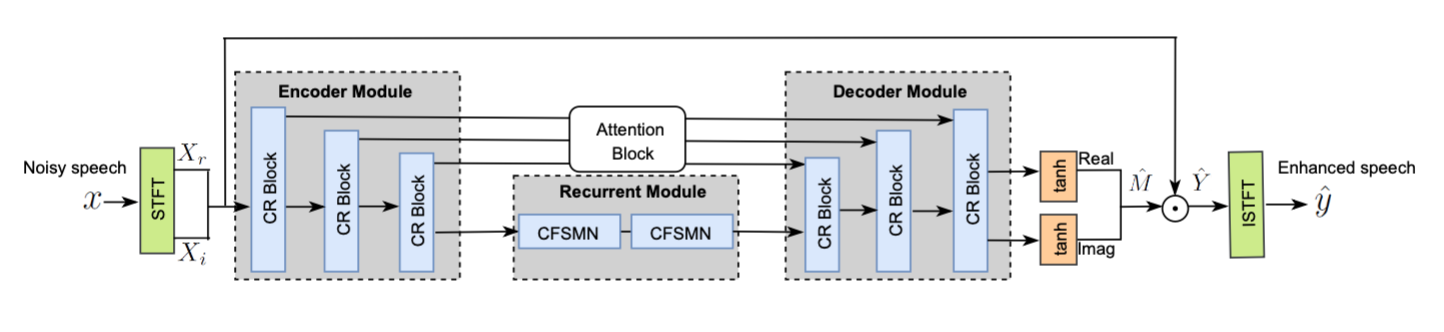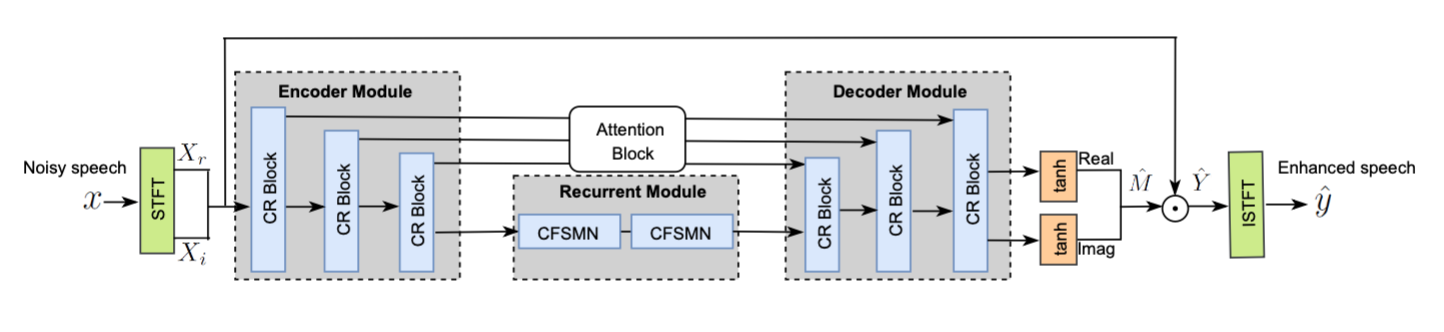

- FRCRN模型网络结构：
    - 模型输入和输出均为16kHz采样率单通道语音时域波形信号，输入信号可由单通道麦克风直接进行录制，输出为噪声抑制后的语音音频信号[1]。模型输入信号通过STFT变换转换成复数频谱特征作为输入，并采用Complex FSMN在频域上进行关联性处理和在时序特征上进行长序处理，预测中间输出目标Complex ideal ratio mask, 然后使用预测的mask和输入频谱相乘后得到增强后的频谱，最后通过STFT逆变换得到增强后语音波形信号。

In [7]:
from modelscope.pipelines import pipeline
from modelscope.utils.constant import Tasks
ans = pipeline(Tasks.acoustic_noise_suppression, model='F:/03Models/speech_frcrn_ans_cirm_16k')
result = ans('./sounds/speech_with_noise1.wav', output_path='./sounds/output.wav')
# 返回输出语音的字节码

2026-02-05 12:21:16,887 - modelscope - INFO - initiate model from F:/03Models/speech_frcrn_ans_cirm_16k
2026-02-05 12:21:16,888 - modelscope - INFO - initiate model from location F:/03Models/speech_frcrn_ans_cirm_16k.
2026-02-05 12:21:16,890 - modelscope - INFO - initialize model from F:/03Models/speech_frcrn_ans_cirm_16k
2026-02-05 12:21:17,254 - modelscope - WARNING - No preprocessor field found in cfg.
2026-02-05 12:21:17,255 - modelscope - WARNING - No val key and type key found in preprocessor domain of configuration.json file.
2026-02-05 12:21:17,255 - modelscope - WARNING - Cannot find available config to build preprocessor at mode inference, current config: {'model_dir': 'F:/03Models/speech_frcrn_ans_cirm_16k'}. trying to build by task and model information.
2026-02-05 12:21:17,256 - modelscope - INFO - No preprocessor key ('speech_frcrn_ans_cirm_16k', 'acoustic-noise-suppression') found in PREPROCESSOR_MAP, skip building preprocessor. If the pipeline runs normally, please igno

inputs:(1, 75165)
padding: 27165
inputs after padding:(1, 102330)


- 代码说明：
    - 语音处理后，输出为语音文件，返回输出语音的字节码。

## 2.2. 音频转音频任务技术分析